# Time Series Tunnel Traffic Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ts-course-data/flu-trends.csv
/kaggle/input/ts-course-data/book_sales.csv
/kaggle/input/ts-course-data/elecdemand.csv
/kaggle/input/ts-course-data/trig.csv
/kaggle/input/ts-course-data/avocados.csv
/kaggle/input/ts-course-data/co2.csv
/kaggle/input/ts-course-data/ar.csv
/kaggle/input/ts-course-data/reserve.csv
/kaggle/input/ts-course-data/us-retail-sales.csv
/kaggle/input/ts-course-data/tunnel.csv
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [3]:
data_path = "../input/ts-course-data/tunnel.csv"
# convert Day column to datetime type
tunnel = pd.read_csv(data_path, parse_dates = ["Day"])

In [4]:
tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [5]:
tunnel = tunnel.set_index("Day")

In [6]:
tunnel = tunnel.to_period()

In [7]:
tunnel.index

PeriodIndex(['2003-11-01', '2003-11-02', '2003-11-03', '2003-11-04',
             '2003-11-05', '2003-11-06', '2003-11-07', '2003-11-08',
             '2003-11-09', '2003-11-10',
             ...
             '2005-11-07', '2005-11-08', '2005-11-09', '2005-11-10',
             '2005-11-11', '2005-11-12', '2005-11-13', '2005-11-14',
             '2005-11-15', '2005-11-16'],
            dtype='period[D]', name='Day', length=747)

In [8]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [9]:
df = tunnel.copy()

In [10]:
df['Time'] = np.arange(len(tunnel.index))

In [11]:
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [12]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Time']]
y = df.loc[:, 'NumVehicles']

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

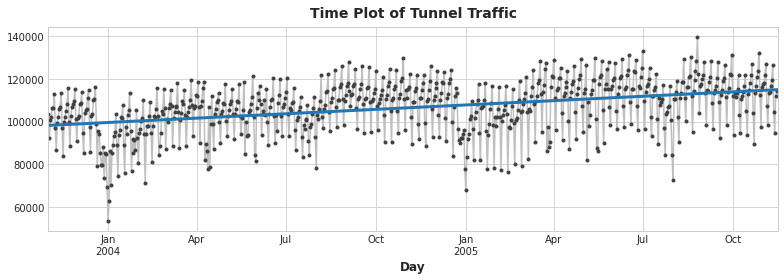

In [13]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## Lag feature

In [14]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [15]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)
y = df.loc[:, 'NumVehicles']
y,X = y.align(X, join = 'inner')

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)

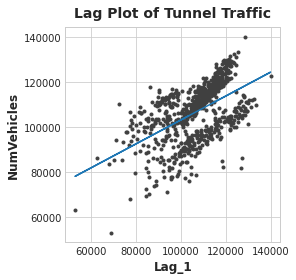

In [16]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

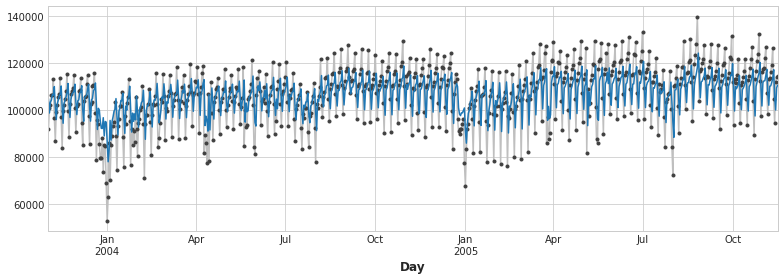

In [17]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## Trend

In [18]:
tunnel

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


In [19]:
moving_average = tunnel.rolling(
    window = 365,
    center = True,
    min_periods = 183,
).mean()

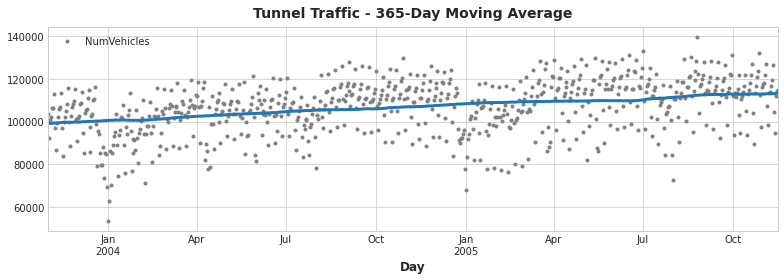

In [20]:
ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

### Use deterministic process

In [21]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,
    order=1,
    drop=True # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [22]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept = False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

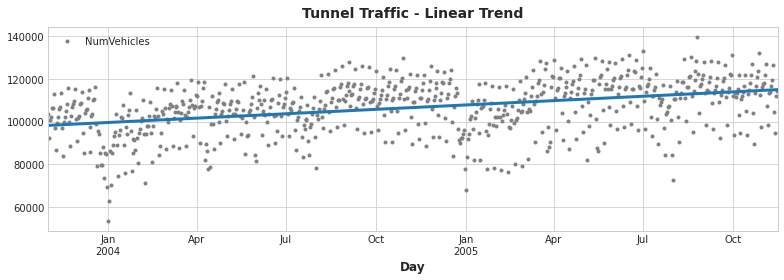

In [23]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [24]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

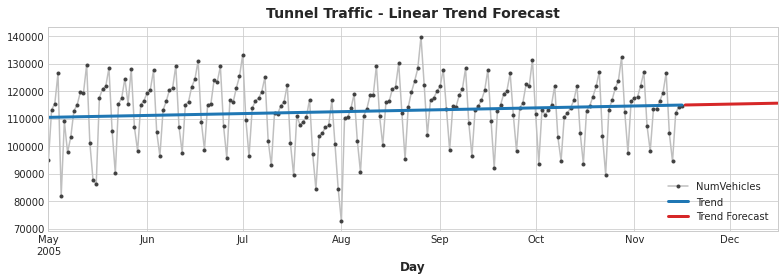

In [25]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Lagged Series and Lag Plots

In [26]:
temp = pd.read_csv("../input/ts-course-data/reserve.csv")
temp.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [27]:
reserve = pd.read_csv(
    "../input/ts-course-data/reserve.csv",
    parse_dates = {'Date': ['Year', 'Month', 'Day']},
    index_col = 'Date'
)
reserve.head()

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
Date,,,,,,,
1954-07-01,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1954-08-01,NaN,NaN,NaN,1.22,NaN,6.0,NaN
1954-09-01,NaN,NaN,NaN,1.06,NaN,6.1,NaN
1954-10-01,NaN,NaN,NaN,0.85,8.0,5.7,NaN
1954-11-01,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [28]:
y = reserve.loc[:, "Unemployment Rate"].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1
